In [2]:
#@title General imports used throughout notebook
import sys, os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV as RandomisedSearchCV

from sklearn.feature_selection import SelectKBest

# Regression

In [ ]:
#@title 
XTrain = np.loadtxt('Regression/X_train.csv', delimiter=',', skiprows = 1)
tTrain = np.loadtxt('Regression/y_train.csv', delimiter=',', skiprows = 1)[:, 1]
XTest = np.loadtxt('Regression/X_test.csv',  delimiter=',', skiprows = 1)

## Visualizing and Analysing the Data

<function matplotlib.pyplot.show>

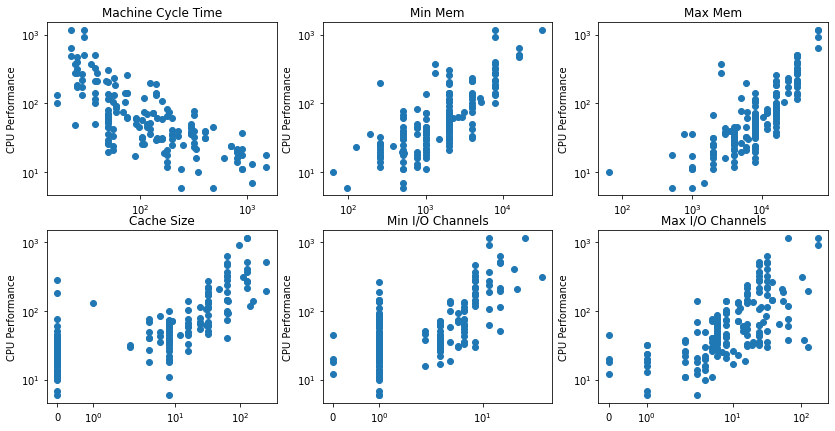

In [ ]:
#@title
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 7))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
titles = ["Machine Cycle Time", "Min Mem", "Max Mem", "Cache Size",
                                         "Min I/O Channels", "Max I/O Channels"]

for i, (ax, title) in enumerate(zip(axes, titles)):
    ax.set_title(title)
    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    ax.set_ylabel("CPU Performance")

    ax.scatter(XTrain[:, i], tTrain)

plt.show

Visualising the data allows us to make several observations. The most notable observation is that, in general, a larger value corresponds to a higher score. This is not always the case however, as we can see several occurrences in which scores of the same value vary seen as "vertical lines" of points in the graphs. For example, the "Min I/O Channels" graph shows that a relatively large number of CPUs score higher with a value of 10^0 than many with larger values.

The only feature that does not support this observation is machine cycle time, in which a lower value gives a higher score. This is representative  of what is considered a "better" CPU than another.

### Scoring features

Sklearn provides a class which allows us to select the K best features based on some scoring function. The function chosen below is the mutual_info_regression scoring function. This function measures the dependency of features on one another in the dataset [5].

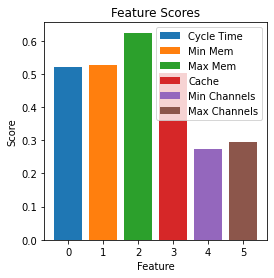

In [ ]:
#@title
from sklearn.feature_selection import mutual_info_regression

#Create feature selector scoring using the mutual_info_regression function
MIFS = SelectKBest(score_func = mutual_info_regression, k = "all")

figure, ax = plt.subplots(1, 1, figsize = (4, 4))

labels = ["Cycle Time", "Min Mem", "Max Mem", "Cache", "Min Channels",
                                                                 "Max Channels"]
MIFS.fit(XTrain, tTrain) #Fit feature selector to training data
ax.set_title("Feature Scores")
ax.set_xlabel("Feature")
ax.set_ylabel("Score")

for i in range(len(MIFS.scores_)):
    ax.bar(i, MIFS.scores_[i], label = labels[i])

ax.legend()
plt.show()

We can see in the above graph that many of the features in the dataset are dependent on one another to different degrees. The highest scoring features relate to the minimum and maximum supported memory and the cache size so it may be desirable to construct new features based on these.

### Some Manual Feature Engineering

Feature engineering is the process by which we are able to remove, select, or create new features using our original dataset [4]. Using the above data we aim to construct four new features: Average memory and channels as the sum of the relevant minimums and maximmums divided by two, range of memory supported as the maximum minus the minimum, and a binary feature to represent whether or not the cache size is 0.

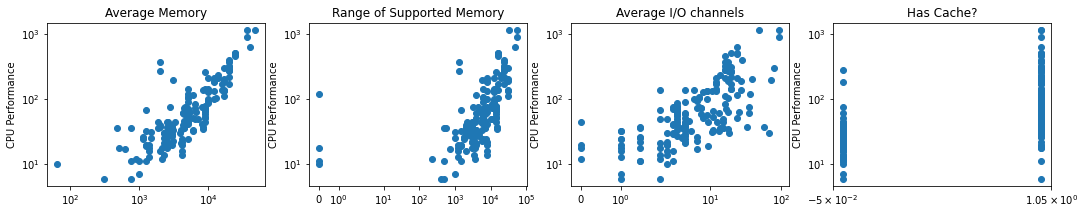

In [ ]:
#@title
hasCache = np.ones(len(tTrain))     #Binary feature
hasCache[XTrain[:, 3] == 0] = 0     #0 if no cache, 1 otherwise

averageMem  = (XTrain[:, 1] + XTrain[:, 2]) / 2     #Average supported memory
memRange    = (XTrain[:, 2] - XTrain[:, 1])         #Range of memory supported
averageChan = (XTrain[:, 4] + XTrain[:, 5]) / 2     #Avg supported IO channels

newFeatures = np.hstack((XTrain, averageMem[:, None], memRange[:, None],
                                       averageChan[:, None], hasCache[:, None]))

figure, axes = plt.subplots(1, 4, figsize = (18, 3))

titles = ["Average Memory", "Range of Supported Memory", "Average I/O channels",
                                                                   "Has Cache?"]
features = [averageMem, memRange, averageChan, hasCache]

for ax, title, feature in zip(axes, titles, features):
    ax.set_title(title)
    ax.set_ylabel("CPU Performance")
    ax.set_xscale("symlog")
    ax.set_yscale("symlog")
    ax.scatter(feature, tTrain)

plt.show()

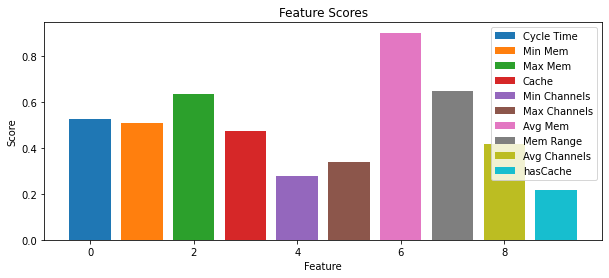

In [ ]:
#@title
figure, ax = plt.subplots(1, 1, figsize = (10, 4))

labels = ["Cycle Time", "Min Mem", "Max Mem", "Cache", "Min Channels",
             "Max Channels", "Avg Mem", "Mem Range", "Avg Channels", "hasCache"]

titles = ["Old Feature Scores", "New Feature Scores"]

MIFS.fit(newFeatures, tTrain)    #Fit selector to data
ax.set_title("Feature Scores")
ax.set_xlabel("Feature")
ax.set_ylabel("Score")

for i in range(len(MIFS.scores_)):
    ax.bar(i, MIFS.scores_[i], label = labels[i])

ax.legend()
plt.show()

We add these features to the dataset in order to compare the new and old features. We can see that some of the new features score incredibly well such as average memory. Due to the relatively high scores of all features, we have chosen to add these below.

In [ ]:
#@title
XTrainNew = newFeatures

avgMem   = (XTest[:, 1] + XTest[:, 2]) / 2  #Average memory
memRange = (XTest[:, 2] - XTest[:, 1])      #Range of memory supported
avgChan  = (XTest[:, 4] + XTest[:, 5]) / 2  #Average supported IO channels
hasCache = np.ones(XTest.shape[0])          #Binary feature
hasCache[XTest[:, 3] == 0] = 0              #0 if no cache, 1 otherwise

XTestNew = np.hstack((XTest, avgMem[:, None], memRange[:, None],
                                           avgChan[:, None], hasCache[:, None]))

# Gaussian Regression with RBF Kernel

In this section we carry out Gaussian regression using an RBF kernel. This is performed using sklearn's GaussianProcessRegressor object with a sklearn RBF object as the kernel. We can create an RBF object as the kernel for our GaussianProcessRegressor as follows:

In [ ]:
#@title
from sklearn.gaussian_process.kernels import RBF


kernel = RBF()

The model employs an optimiser in order to optimise the kernel's parameters. By default this uses sklearn's built-in "fmin_l_bfgs_b", however this optimiser sometimes fails to converge in the current task. Instead we have opted for a custom optimiser function shown below. This function is passed an objective function and a set of parameters by the optimiser and then uses scipy's minimise to optimise the kernel's parameters. The method used by the optimiser is "Nelder-Mead", this is a widely used algorithm for estimating parameters that does not require derivative information [1]. The method is also suitable for non-smooth or non-continuous functions.

In [ ]:
#@title
from scipy.optimize import minimize


def customOpt(objFunc, theta, bounds):
    """
     * Custom optimisation function for Gaussian regression using RBF kernel.
     * Uses Nelder-Mead with 500 max iterations before convergence.
     """
    result = minimize(objFunc, theta, method = "Nelder-Mead", jac = True,
                                    bounds = bounds, options = {"maxiter": 500})

    return result.x, result.fun #Return optimal theta and function

Here we create the model with some pre-set parameters. We set the model's kernel to be the RBF kernel above and set the optimiser to our custom optimiser function.

In [ ]:
#@title
from sklearn.gaussian_process import GaussianProcessRegressor


gaussianModel = GaussianProcessRegressor(kernel = kernel, optimizer = customOpt)

Here we define candidate parameters for our model. The dictionary keys are the names of the model parameters and the associated lists are the candidate values. These candidate values are selected manually within a sensible range.

In [ ]:
#@title 
params = {"alpha": [1e-10, 1e-9, 1e-8, 1e-5, 1e-2, 1, 2, 3, 10, 20],
          "n_restarts_optimizer": [1, 10, 15]}

Here we define a GridSearchCV object. This is a class provided by the sklearn library [6] that will conduct an exhaustive search over all combinations of the above parameters. We opt for an exhaustive search due to the relatively small amount of parameter combinations. Once a combination of parameters has been applied to the model, 10-fold cross validation will be carried out in order to assess potential test-losses of the model with the chosen parameters.

In [ ]:
#@title 
gaussGridSearch = GridSearchCV(gaussianModel, params, scoring = "max_error",
                                                          refit = True, cv = 10)

Here we create a sklearn Pipeline object [7]. This simply passes the data to each object in the pipeline and performs the relevant fitting and transformations at each stage. We include a StandardScaler [2] at the start of the pipeline which scales the data by removing the mean and scaling to unit variance. This will be performed before we carry out random search cross-validation.

Calling fit on the pipeline will fit the training data to the scaler and transform it. After this the grid search will be fit to the training data, in turn the class will carry out cross-validation with all parameter combinations as defined above. We also instructed the grid search to refit the model with the optimal parameter combination, and we are now able to perform model operations such as scoring and predicting directly using the pipeline object.

In [ ]:
#@title 
pipe = make_pipeline(StandardScaler(), gaussGridSearch)    #Create pipeline
pipe.fit(XTrainNew, tTrain) #Fit objects in pipeline to train data and labels

#NOTE: This cell will output a lot of warnings due to providing jac as True and
#bounds while using the Nelder-Mead algorithm in customOpt. Removing these from 
#the arguments causes the function to return an error. May take a while to run.

A model will be created for each parameter combination, therefore the above process will yield 30 models to inspect. We are able to retrieve the test losses over cross-validation in order to evaluate the performance of these models.

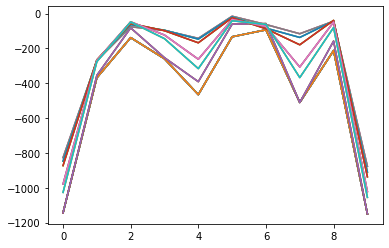

In [ ]:
#@title 
rbfResults  = gaussGridSearch.cv_results_

rbfTestFoldScores = np.vstack([ #Retrieve the test fold scores for each model
    np.array(rbfResults["split" + str(i) + "_test_score"]) for i in range(10)
])

for i in range(rbfTestFoldScores.shape[1]):  #Plot each model
    plt.plot([i for i in range(rbfTestFoldScores.shape[0])], 
                                            rbfTestFoldScores[:, i])

plt.show()

While the above graph gives us an overview of the performance of each model during cross-validation, it does not provide much information and is quite clustered due to the similar performances of several models. A more useful visualisation might be to check the mean of the test-fold scores, shown below.

Text(0, 0.5, 'Positive Avg Loss')

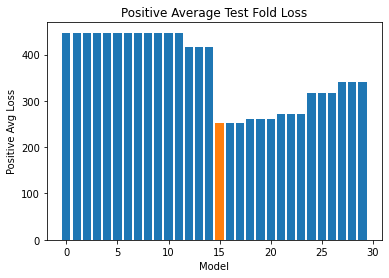

In [ ]:
#@title 
rbfMeanScores = (-1) * rbfResults['mean_test_score']

plt.bar([i for i in range(len(rbfMeanScores))], rbfMeanScores) #Plot mean scores

allMins = np.where(rbfMeanScores == np.min(rbfMeanScores))[0] #Get allmin scores
plt.bar(allMins, rbfMeanScores[allMins])
plt.title("Positive Average Test Fold Loss")
plt.xlabel("Model")
plt.ylabel("Positive Avg Loss")

We can see the average (positive) test-fold losses for all parameter combinations. Many of the models exhibit similar performance to other models on the test folds. We may opt for the best scoring model (shown in orange) based on its average mean test-fold loss. Our GridSearchCV instance has already refit the gaussian model with the "optimal" parameters in this respect, and therefore we are able to make predictions using the earlier-defined pipeline.

In [ ]:
#@title
print("Training Score:", pipe.score(XTrainNew, tTrain))
yPred = pipe.predict(XTestNew)

Training Score: -435.0648984179461


# SGD

For the second regression model we have opted to use stochastic gradient descent. Stochastic gradient descent was chosen as its stochastic nature may discourage local optima and cause the agent to locate global optima instead. The process used for developing the model and analysing its outputs is much the same as the above when using Gaussian Regression with RBF so explanations will be minimial unless different approaches have been used.

In [ ]:
#@title 
from sklearn.linear_model import SGDRegressor

#15000 max iterations before convergence
sgdModel = SGDRegressor(max_iter = 15000)

In [ ]:
#@title 
params = {
    "loss": ["squared_error", "huber", "epsilon_insensitive", 
                                                 "squared_epsilon_insensitive"],
    "penalty":       ["l1", "l2", "elasticnet"],
    "learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
    "alpha":         [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5],
    "l1_ratio":      [0.5, 0.15, 0.25, 0.5],
    "epsilon":       [0.001, 0.01, 0.1, 0.25, 0.5],
    "eta0":          [0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8],
    "power_t":       [0.5, 0.15, 0.25, 0.35, 0.5]
}

The sklearn SGD model has many different parameters to tune as can be seen in the above cell. We can calculate the number of combinations of parameters as the product of the number of each, resulting in a total amount of roughly 115,000 parameter combinations. An exhaustive search would take far too long to find an optimal set of parameters, so here we have opted for a randomised search. The sklearn RandomisedSearchCV class [6] provides a utility for carrying out cross-validation in conjunction with a random search over the defined parameter space. This allows us to apply a random combination of parameters to the model each time we carry out cross validation in an attempt to find the "optimal" parameters. We use a very similar configuration for the RandomisedSearchCV class, with the exception of the n_iter parameter indicating how many parameter combinations the model should attempt.

In [ ]:
#@title 
SGDRandomSearch = RandomisedSearchCV(sgdModel, params, n_iter = 2500, 
                                   scoring = "max_error", refit = True, cv = 10)

We also create a pipeline with a standard scaler as described previously. We will use this pipeline object to conduct all future operations on the model.

In [ ]:
#@title 
pipe = make_pipeline(StandardScaler(), SGDRandomSearch)    #Create pipeline
pipe.fit(XTrainNew, tTrain) #Fit objects in pipeline to train data and labels

#NOTE: This cell may take a while to run. It may also produce convergence
#warnings as the model does not converge within the max iterations with certain
#parameter combinations.

In [ ]:
#@title
sgdResults = SGDRandomSearch.cv_results_

Text(0, 0.5, 'Positive Avg Loss')

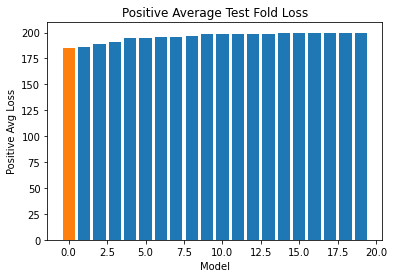

In [ ]:
#@title 
sgdMeanScores = (-1) * sgdResults['mean_test_score']
best20 = np.argsort(sgdMeanScores)[:20]
sgdMeanScores = sgdMeanScores[best20]    #Get 20 best models

plt.bar([i for i in range(len(sgdMeanScores))], sgdMeanScores) #Plot mean scores
allMins = np.where(sgdMeanScores == np.min(sgdMeanScores))[0] #Get allmin scores
plt.bar(allMins, sgdMeanScores[allMins])
plt.title("Positive Average Test Fold Loss")
plt.xlabel("Model")
plt.ylabel("Positive Avg Loss")

The above random search will provide us results for all different models tested by the random parameter search, and therefore analysing all results will not be very informative. We have again chosen to select the best model based on the best average test-fold losses. The above bar chart shows the (positive) losses of the top 20 best-performing models. In orange can be seen the model with the best score, or lowest positive loss, and therefore we have opted to use this model for predictions. We have instructed the RandomisedSearchCV class to refit the model with optimal parameter settings, so we may directly predict data with this through the earlier-defined pipeline as before.

In [ ]:
#@title
print("Training Score:", pipe.score(XTrainNew, tTrain))
yPred = pipe.predict(XTestNew)

Training Score: -666.5414253603069


# Classification

In [ ]:
#@title 
XTrain = np.loadtxt('Classification/X_train.csv', delimiter=',', skiprows = 1)
tTrain= np.loadtxt('Classification/y_train.csv',delimiter=',', skiprows=1)[:, 1]

XTest = np.loadtxt('Classification/X_test.csv',  delimiter=',', skiprows = 1)

# Visualising the Data

The classification data contains 112 features for each input. As a result this means that we are not realistically able to visualise the data with any certainty. We can however approach visualising the data using sklearn's TSNE class. TSNE [9] will convert similarities between data into joint probabilities and attempt to embed the high-dimensional data in a low-dimensional dataset. This allows us to visualise an approximation of the high dimensional dataset provided.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


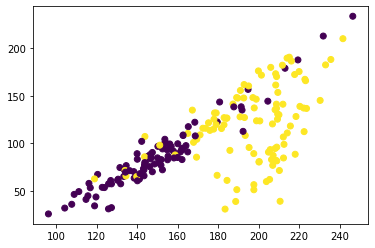

In [ ]:
#@title 
from sklearn.manifold import TSNE

XTrain2D = TSNE(learning_rate = "auto", init = "pca",
                n_components = 2).fit_transform(XTrain, tTrain)
plt.scatter(XTrain[:, 0], XTrain[:, 1], c = tTrain)

## Analysing the Data
As in the regression task, we can score the data using sklearn's SelectKBest class. Here we use the mutual_info_classif [5] scoring function, which functions in a similar way to mutual_info_regression described previously. This allows us to effectively view how relevant the individual features are in relation to other features of the data and score them appropriately.

In [ ]:
#@title 
from sklearn.feature_selection import mutual_info_classif

#Create feature selector scoring using the mutual_info_classif function
MIFS = SelectKBest(score_func = mutual_info_classif, k = "all")
MIFS = MIFS.fit(XTrain, tTrain)

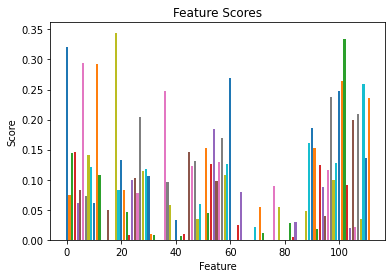

In [ ]:
#@title 
figure, ax = plt.subplots(1, 1, figsize = (6, 4))

ax.set_title("Feature Scores")
ax.set_xlabel("Feature")
ax.set_ylabel("Score")

for i in range(len(MIFS.scores_)):
    ax.bar(i, MIFS.scores_[i])

plt.show()

It appears that there are a number of "well" scoring features, considering the maximum scoring feature does not score that high. Instead of opting for a manual feature engineering and selection approach as was carried out in the regression task, for the classification task principle component analysis will be employed to reduce the features of the dataset as described below.

## Logistic Regression

Due to the large number of features of each data point, it is desirable to reduce this number to a more managable amount which preserves the important structure of the underlying dataset. We are able to approach this task using principle component analysis, or PCA. This is a technique which allows us to reduce the dimensionality of a dataset using singular value decomposition (SVD) while retaining important aspects of the data [10].

Below we use a basic LogisticRegression model with default parameters in order to test how the model performs with data reduced to a certain amount of features. We use the cross validation score provided by sklearn's cross_val_score [11] in order to assess the performance of the model at each feature reduction.

In [ ]:
#@title 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

allScores  = []
meanScores = []

for i in range(1, XTrain.shape[1]): #Iteratefrom 0 to n features and reduce to i
    currentPipe = make_pipeline(PCA(n_components = i), StandardScaler(),
                                                           LogisticRegression())
    score = cross_val_score(currentPipe, XTrain, y = tTrain,
                           scoring = "accuracy", cv = 10, error_score = "raise")

    allScores.append(score)
    meanScores.append(np.mean(score))

In [ ]:
#@title
bestIndices = np.argsort(meanScores)[::-1][:20] #Get top 20 by mean score

bestScores = []
bestMeans  = []

for index in bestIndices:
    bestScores.append(allScores[index])
    bestMeans.append(meanScores[index])

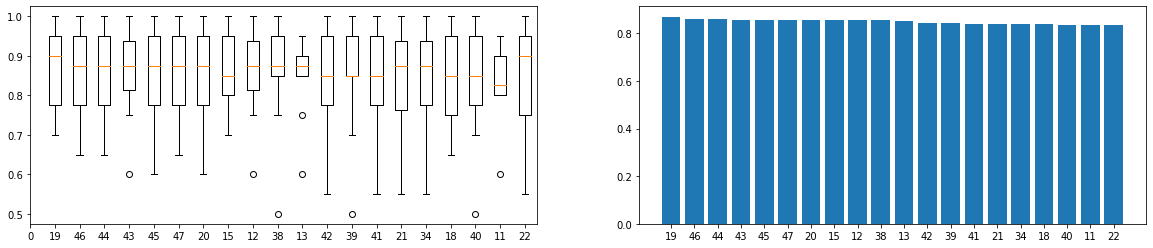

In [ ]:
#@title 
figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 4))

ax1.boxplot(bestScores)

ax1.set_xticks(np.arange(len(bestIndices) + 1))
ax1.set_xticklabels([0] + list(bestIndices))

ax2.bar([i for i in range(20)], bestMeans)

ax2.set_xticks(np.arange(len(bestIndices)))
ax2.set_xticklabels(bestIndices)

plt.show()

The entire set of model scores and mean model scores will not be very informative due to the amount of data. Due to this fact, we have opted to select the top 20 best-scoring models based on the mean score of each. In the simplified box plot above we can see that there are many feature reductions that perform well. The "best" performing model in our case, according to average test-loss accuracy, seems to be when the data has been reduced to 19 features. The bar graph summarises the mean scores and validates that there are several well-performing models. For the final model we will opt for the feature reduction that resulted in the model with the best mean score.

We can create the model with some pre-set parameters that we will not vary below. Here we set the maximum iterations before convergence to 7500 and the class weight to balanced. Setting the class weight to balanced may aid the performance of our model if the data is unbalanced, however this is mainly a precautionary measure due to the fact that we scale the data using sklearn's StandardScaler.

In [ ]:
#@title
lrModel = LogisticRegression(max_iter = 7500, class_weight = "balanced")

As with cross-validation in the previous models, here we list a number of parameters that will be varied during the cross-validation process. We opt for the liblinear solver as this is well-suited to smaller data sets such as ours. This model only functions with the l1 and l2 penalties, so we will only use these.

In [ ]:
#@title 
lrParams = {
    "solver": ["liblinear"],
    "penalty": ["l2", "l1"],
    "fit_intercept": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1,
                                              1.2, 1.3, 1.4, 1.5, 2, 5, 10, 15],
    "C": [0.001, 0.01, 0.1, 0.15, 0.25, 0.5, 1.0, 1.25, 1.5, 5, 10,
                                                                25, 50, 75, 100]
}

Here we conduct random search cross-validation as we performed with SGD. Again this allows us to find potentially optimal parameter settings within a relatively small number of iterations.

In [ ]:
#@title 
lrRandomSearch = RandomisedSearchCV(lrModel, lrParams, n_iter = 500,
                                    scoring = "accuracy", refit = True, cv = 5)

At the start of our pipeline we place a PCA object that will transform our input dataset by reducing the features to the desired number. In this case we reduce the features to the number of features used by the model with the highest average score earlier.

In [ ]:
#@title 
lrPipe = make_pipeline(PCA(n_components = bestIndices[0]),
                                               StandardScaler(), lrRandomSearch)

lrPipe.fit(XTrain, tTrain) #Fit objects in pipeline to train data adn labels

As we have done for the regression task, we may fit, score, and predict using the pipeline object itself.

In [ ]:
#@title
results = lrRandomSearch.cv_results_

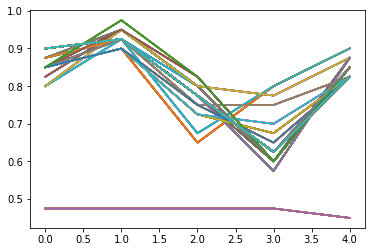

In [ ]:
#@title 
testFoldScores = np.vstack([ #Retrieve the test fold scores for each model (column)
    np.array(results["split" + str(i) + "_test_score"]) for i in range(5)
])

for i in range(testFoldScores.shape[1]):  #Iterate over all models
    plt.plot([i for i in range(testFoldScores.shape[0])], testFoldScores[:, i])    #Plot test fold losses

plt.show()

In [ ]:
#@title
print("Training Score: ", lrPipe.score(XTrain, tTrain))

Training Score:  0.9


The above graph shows the test-losses of each of the 20 best-performing models over 5-fold cross-validation. We can observe a similarity shared by many of the models, that is that several models perform better on the earlier test-folds than on the later test-folds. We may attempt to improve this performance on the later test-folds through the use of bagging.

### Logistic Regression with Bagging

Due to the quick execution of our model it may be desirable to attempt to improve performance through the use of bootstrap aggregation, or bagging. This is called an ensemble method in which the predictions of several estimators are combined in order to improve robustness [3]. In bagging [3], we combine the predictions of several estimators, for example through averaging, in order to return a final prediction. In this particular instance of bagging we train a series of models on random samples of the data, either sampled with replacement or not, in order to improve the robustness of our base classifier. We also opt to sample the amount of features which will be used when training the model which may also improve the performance of our final model.

In [ ]:
#@title 
from sklearn.ensemble import BaggingClassifier


lrBagModel = BaggingClassifier(base_estimator = lrModel)

We are able to perform random search cross-validation in this model too, we vary the parameters of the "outer" model, in this case the bagging model, by entering its parameters into the dictionary below, and we are able to vary the parameters of the "inner" estimators, our logistic regression models, by prefixing the names of the parameters with "base_estimator__[parameter name]". Here we vary the number of estimators used by the bagging model, the number of random samples and features each model is trained using.

In [ ]:
#@title 
lrBagParams = {
    "n_estimators": [5, 10, 15],    #Num of estimators to use
    "max_samples": [0.6, 0.8, 1.0], #% samples of train data for estimators
    "max_features": [0.6, 0.8, 1.0],#% features of training data for estimators
    "bootstrap": [True],            #Sample with replacement
    "base_estimator__solver": ["liblinear"],
    "base_estimator__penalty": ["l2", "l1"],
    "base_estimator__fit_intercept": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                               0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 5, 10, 15],
    "base_estimator__C": [0.001, 0.01, 0.1, 0.15, 0.25, 0.5, 1.0, 1.25, 1.5, 5,
                                                            10, 25, 50, 75, 100]
}

As before we can simply create a RandomisedSearchCV instance and pass it our bagging model as the estimator.

In [ ]:
#@title 
lrBagRandomSearch = RandomisedSearchCV(lrBagModel, lrBagParams, n_iter = 500,
                                    scoring = "accuracy", refit = True, cv = 10)

lrBagPipe = make_pipeline(PCA(n_components = bestIndices[0]), StandardScaler(),
                                      lrBagRandomSearch)    #Create pipeline

lrBagPipe.fit(XTrain, tTrain) #Fit objects in pipeline to train data and labels

#Note: This cell may produce convergence warnings for some param combinations

In [ ]:
#@title
lrBagResults = lrBagRandomSearch.cv_results_

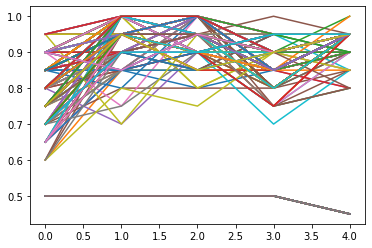

In [ ]:
#@title 
lrBagTestFoldScores = np.vstack([ #Retrieve the test fold scores for each model
    np.array(lrBagResults["split" + str(i) + "_test_score"]) for i in range(5)
])

for i in range(lrBagTestFoldScores.shape[1]):  #Plot all test fold losses for models
    plt.plot([i for i in range(lrBagTestFoldScores.shape[0])],
                                            lrBagTestFoldScores[:, i])

plt.show()

The above plot, although messy, shows that the use of bagging has removed the earlier observation of models performing badly on certain test-folds. Bagging may provide a slight improvement to our final model, however I believe that logistic regression is considered a stable model. Bagging is usually employed in the case of an unstable model in order to improve overall performance, and as a result the performance of logistic regression may not see a large improvement.

In [ ]:
#@title
print("Training Score: ", lrBagPipe.score(XTrain, tTrain))
yPred = lrBagPipe.predict(XTest)

Training Score:  0.91


# SVM

For the second classification algorithm, we employ an SVM model. As with logistic regression, we can test PCA feature reduction on a basic model with default parameters in order to determine the "optimal" number of features to use. Again, the process is much the same as with the previous model and therefore explanations will be minimal unless different processes are used.

In [ ]:
#@title 
from sklearn.svm import SVC

allScores  = []
meanScores = []

for i in range(1, XTrain.shape[1]):
    currentPipe = make_pipeline(PCA(n_components = i), StandardScaler(), SVC())
    score = cross_val_score(currentPipe, XTrain, y = tTrain,
                           scoring = "accuracy", cv = 10, error_score = "raise")

    allScores.append(score)
    meanScores.append(np.mean(score))

In [ ]:
#@title
bestIndices = np.argsort(meanScores)[::-1][:20] #Get top 20 by mean score

bestScores = []
bestMeans  = []

for index in bestIndices:
    bestScores.append(allScores[index])
    bestMeans.append(meanScores[index])

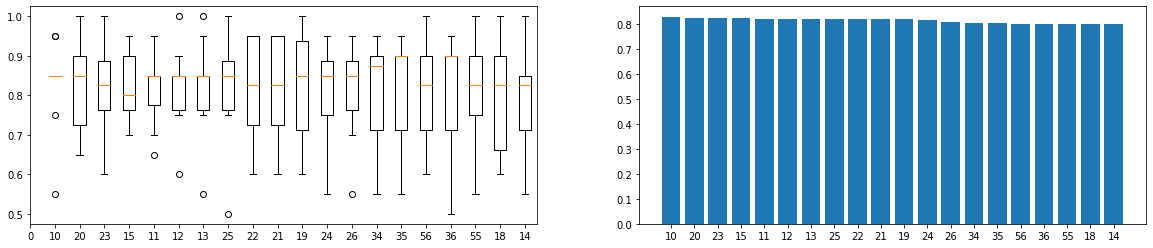

In [ ]:
#@title 
figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 4))

ax1.boxplot(bestScores)

ax1.set_xticks(np.arange(len(bestIndices) + 1))
ax1.set_xticklabels([0] + list(bestIndices))

ax2.bar([i for i in range(20)], bestMeans)

ax2.set_xticks(np.arange(len(bestIndices)))
ax2.set_xticklabels(bestIndices)

plt.show()

Again the full box plot will not be very informative, so we limit our view to the top 20 average scoring models. The box plot shows that the scores seem to vary similarly to with logistic regression. A simple bar chart implies that if we use the best average score a PCA reduction to 10 features may provide optimal results for our SVM model.

We can create an SVM model using sklearn's SVC below. We use an RBF kernel and set class weights to balanced in an attempt to improve our model's performance in the presence of unbalanced weights. Again this is a precautionary measure as our data will be scaled to unit variance with mean removed using StandardScaler.

In [ ]:
#@title
svmModel = SVC(kernel = "rbf", class_weight = "balanced")

Here we vary the parameters of our SVM model using a similar process as before, we then conduct random search cross-validation to find the optimal set of parameters for the model, create a simple pipeline for our process and fit it to the training data.

In [ ]:
#@title 
smvParams = {
    "C": [0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.5, 5, 10, 25,
                                                                   50, 75, 100],
    "gamma": ["scale", "auto", 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.5,
                                                        5, 10, 25, 50, 75, 100],
    "shrinking": [True, False],
    "decision_function_shape": ["ovo", "ovr"]
}

In [ ]:
#@title 
svmRandomSearch = RandomisedSearchCV(svmModel, smvParams, n_iter = 1000, 
                           scoring = "balanced_accuracy", refit = True, cv = 10)

svmPipe = make_pipeline(PCA(n_components = bestIndices[0]),
                            StandardScaler(), svmRandomSearch)  #Create pipeline

svmPipe.fit(XTrain, tTrain) #Fit objects in pipeline to train data and labels

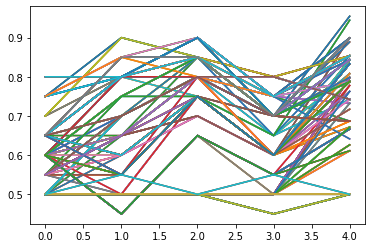

In [ ]:
#@title 
results = svmRandomSearch.cv_results_

testFoldScores = np.vstack([ #Retrieve the test fold scores for each model
    np.array(results["split" + str(i) + "_test_score"]) for i in range(5)
])

for i in range(testFoldScores.shape[1]):  #Plot test fold losses
    plt.plot([i for i in range(testFoldScores.shape[0])], testFoldScores[:, i])

plt.show()

In [ ]:
#@title
print("Training Score: ", svmPipe.score(XTrain, tTrain))
yPred = svmPipe.predict(XTest)

Training Score:  0.8500602167804094


The plot here again shows test-losses of models with randomly selected parameter combinations over cross-validation. Some parameter settings are far from optimal, and others seem to perform quite well over all test folds. We can see an overall training score similar to logistic regression, however a submission using the true test data has shown SVM to provide a potentially more accurate prediction than logistic regression.

Several attempts were made to improve the performance of the SVM model including bagging [3] as in the LR pipeline, and stacking [3] which is a process similar to bagging that combines the predictions of several *different* estimators in order to reduce biases and improve predictions. Stacking attempts included stacking SVM with LR and KNN, however no improvements were made to the overall performance of the model.

#References

[1] Saša Singer and John Nelder, (2009), "Nelder-Mead Algorithm", Retrieved from: http://www.scholarpedia.org/article/Nelder-Mead_algorithm

[2] Sklearn, (NA), "Preprocessing Data", Retrieved from: https://scikit-learn.org/stable/modules/preprocessing.html

[3] Sklearn, (NA), "Ensemble Methods", Retrieved from: https://scikit-learn.org/stable/modules/ensemble.html

[4] Jason Brownlee, (2014), "Discover Feature Engineering, How to Engineer Features and How to Get Good at it", Retrieved from: https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

[5] Sklearn, (NA), "Feature Selection", Retrieved from: https://scikit-learn.org/stable/modules/feature_selection.html

[6] Sklearn, (NA), "Tuning the Hyperparameters of an Estimator", Retrieved from: https://scikit-learn.org/stable/modules/grid_search.html

[7] Sklearn, (NA), "Pipelines and Composite Estimators", Retrieved from: https://scikit-learn.org/stable/modules/compose.html

[9] Sklearn, (NA), "Manifold Learning", Retrieved from: https://scikit-learn.org/stable/modules/manifold.html

[10] Sklearn, (NA), "Decomposing Signals in Components (Matrix Factorization Problems)", Retrieved from: https://scikit-learn.org/stable/modules/decomposition.html

[11] Sklearn, (NA), "Cross-Validation: evaluating estimator performance", Retrieved from: https://scikit-learn.org/stable/modules/cross_validation.html